# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Group Normalization

In [13]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=32):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, out_channels)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, out_channels)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x += shortcut
        x = self.elu(x)
        return x
    
class CustomResNet_GN(nn.Module):
    def __init__(self, num_groups=32):
        super(CustomResNet_GN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, 32)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, 64)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, num_groups)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn3 = nn.GroupNorm(num_groups, 128)
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.gn4 = nn.GroupNorm(num_groups, 256)
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, num_groups)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.gn3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.gn4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

## Load Dataset

In [14]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [16]:
# Model, optimizer, and scheduler
model = CustomResNet_GN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [17]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_GN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn1): GroupNorm(32, 32, eps=1e-05, affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d

In [18]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [20]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 1.9472, Train Accuracy: 51.78%, Val Loss: 1.9243, Val Accuracy: 53.90%
Epoch: 2, Train Loss: 1.8998, Train Accuracy: 56.56%, Val Loss: 1.8620, Val Accuracy: 60.54%
Epoch: 3, Train Loss: 1.8708, Train Accuracy: 59.39%, Val Loss: 1.8694, Val Accuracy: 59.30%
Epoch: 4, Train Loss: 1.8438, Train Accuracy: 62.12%, Val Loss: 1.8379, Val Accuracy: 62.46%
Epoch: 5, Train Loss: 1.8294, Train Accuracy: 63.39%, Val Loss: 1.8350, Val Accuracy: 62.52%
Epoch: 6, Train Loss: 1.8084, Train Accuracy: 65.54%, Val Loss: 1.7998, Val Accuracy: 66.34%
Epoch: 7, Train Loss: 1.8013, Train Accuracy: 66.29%, Val Loss: 1.7960, Val Accuracy: 66.54%
Epoch: 8, Train Loss: 1.7942, Train Accuracy: 66.95%, Val Loss: 1.7920, Val Accuracy: 66.96%
Epoch: 9, Train Loss: 1.7803, Train Accuracy: 68.30%, Val Loss: 1.7867, Val Accuracy: 67.50%
Epoch: 10, Train Loss: 1.7783, Train Accuracy: 68.36%, Val Loss: 1.7883, Val Accuracy: 67.38%
Epoch: 11, Train Loss: 1.7725, Train Accuracy: 68.96%, Val Loss: 1.77

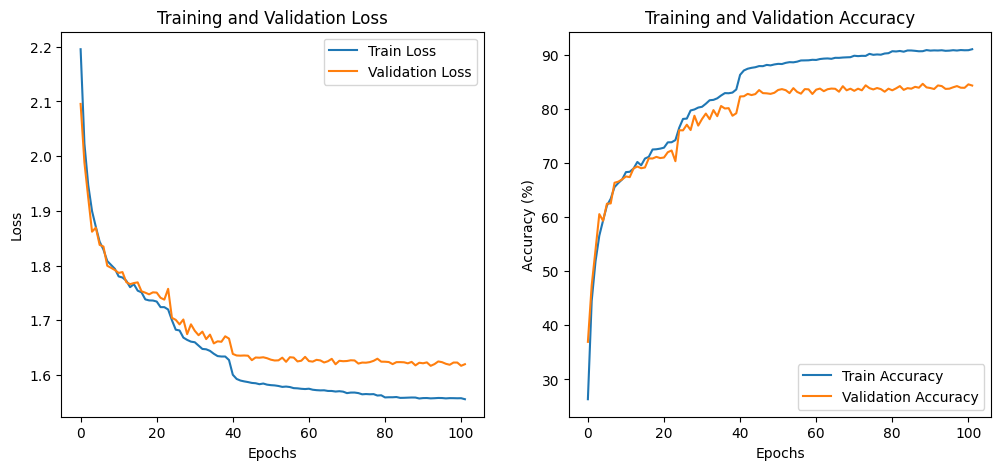

Best Validation Accuracy: 84.62%
Test Accuracy of the final model: 84.86%


In [21]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_GN.pth')

# Layer Wise analyse , Part C

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1_ky8zlEMZSIw-Hbf_sS6-FeBPtpiwfDd"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [3]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [4]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=32):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, out_channels)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, out_channels)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x += shortcut
        x = self.elu(x)
        return x
    
class CustomResNet_GN(nn.Module):
    def __init__(self, num_groups=32):
        super(CustomResNet_GN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups, 32)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups, 64)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64, num_groups)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.gn3 = nn.GroupNorm(num_groups, 128)
        self.elu3 = nn.ELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.gn4 = nn.GroupNorm(num_groups, 256)
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256, num_groups)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.gn2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.gn3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.gn4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

In [5]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.15 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Instantiate and load the model
model = CustomResNet_GN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_GN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_GN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn1): GroupNorm(32, 32, eps=1e-05, affine=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gn3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (elu3): ELU(alpha=1.0)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d

In [8]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {''}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [10]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.07it/s]


### Calc SI

In [11]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 365.58it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7468.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7113.81it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7620.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7901.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7961.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6848.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7551.86it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7573.68it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7796.10it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8172.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7967.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7468.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6760.64it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7441.99it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7259.09it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7259.09it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7135.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6200.92it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7304.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8019.70it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7568.21it/s]


In [12]:
si_layer_train

[('conv1', 0.24329999089241028),
 ('gn1', 0.36629998683929443),
 ('elu1', 0.3723999857902527),
 ('conv2', 0.34109997749328613),
 ('gn2', 0.40849998593330383),
 ('elu2', 0.4075999855995178),
 ('maxpool1', 0.49939998984336853),
 ('resblock1', 0.5845999717712402),
 ('conv3', 0.6193000078201294),
 ('gn3', 0.6291999816894531),
 ('elu3', 0.6287999749183655),
 ('maxpool2', 0.6484999656677246),
 ('conv4', 0.6733999848365784),
 ('maxpool3', 0.6931999921798706),
 ('gn4', 0.6759999990463257),
 ('elu4', 0.6782000064849854),
 ('resblock2', 0.7906999588012695),
 ('avgpool', 0.7879999876022339),
 ('flatten', 0.7879999876022339),
 ('fc1', 0.7797999978065491),
 ('fc2', 0.7760999798774719),
 ('softmax', 0.7576000094413757)]

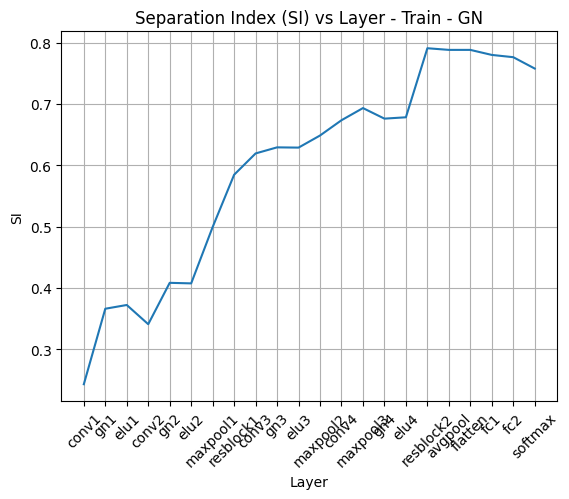

In [13]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Train - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [14]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 919.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4585.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4709.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4186.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4458.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4330.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3080.88it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3448.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4423.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4411.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4614.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4278.16it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3620.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4068.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3315.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3304.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4497.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4304.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4372.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4563.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4737.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4470.59it/s]


[('conv1', 0.34279999136924744), ('gn1', 0.3698999881744385), ('elu1', 0.3790999948978424), ('conv2', 0.4074999988079071), ('gn2', 0.41269999742507935), ('elu2', 0.4274999797344208), ('maxpool1', 0.4908999800682068), ('resblock1', 0.5773000121116638), ('conv3', 0.6024999618530273), ('gn3', 0.6060000061988831), ('elu3', 0.6133999824523926), ('maxpool2', 0.6263999938964844), ('conv4', 0.6448000073432922), ('maxpool3', 0.6796000003814697), ('gn4', 0.6468999981880188), ('elu4', 0.6556999683380127), ('resblock2', 0.814799964427948), ('avgpool', 0.8394999504089355), ('flatten', 0.8394999504089355), ('fc1', 0.8425999879837036), ('fc2', 0.8246999979019165), ('softmax', 0.848800003528595)]


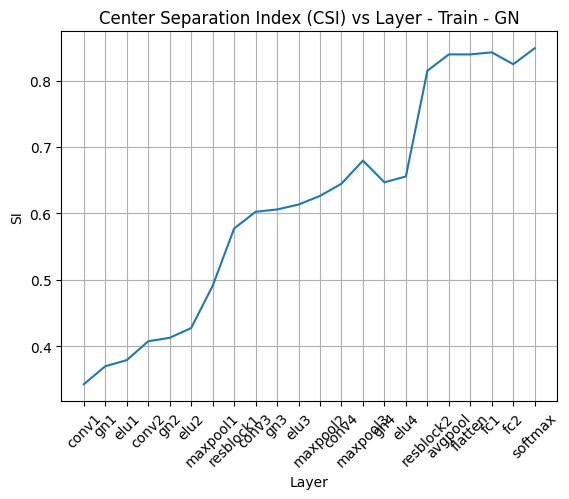

In [15]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Train - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 20.76it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 218.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4852.65it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5084.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5236.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5049.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5047.30it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5021.11it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5280.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5497.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4999.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5102.56it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4309.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5182.42it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4926.75it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5291.38it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5110.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5216.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4979.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4946.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5345.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5214.63it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4852.65it/s]


In [10]:
si_layer_val

[('conv1', 0.2425999939441681),
 ('gn1', 0.32999998331069946),
 ('elu1', 0.33820000290870667),
 ('conv2', 0.3190000057220459),
 ('gn2', 0.3707999885082245),
 ('elu2', 0.37439998984336853),
 ('maxpool1', 0.462799996137619),
 ('resblock1', 0.5491999983787537),
 ('conv3', 0.5881999731063843),
 ('gn3', 0.5931999683380127),
 ('elu3', 0.5924000144004822),
 ('maxpool2', 0.6237999796867371),
 ('conv4', 0.6545999646186829),
 ('maxpool3', 0.6805999875068665),
 ('gn4', 0.6599999666213989),
 ('elu4', 0.6631999611854553),
 ('resblock2', 0.8169999718666077),
 ('avgpool', 0.8473999500274658),
 ('flatten', 0.8473999500274658),
 ('fc1', 0.8473999500274658),
 ('fc2', 0.8499999642372131),
 ('softmax', 0.839199960231781)]

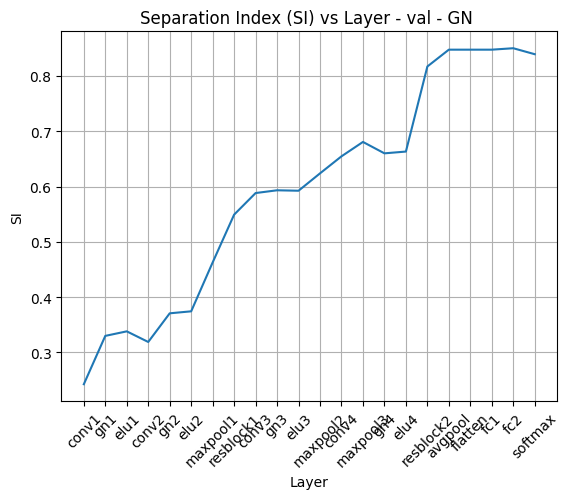

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - GN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 454.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3366.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3321.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3504.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3225.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2872.81it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3109.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2946.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3126.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3185.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2925.58it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3207.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3100.00it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2791.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3326.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3284.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1147.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2305.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2240.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3369.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3426.72it/s]


[('conv1', 0.3330000042915344), ('gn1', 0.3718000054359436), ('elu1', 0.3813999891281128), ('conv2', 0.4147999882698059), ('gn2', 0.4205999970436096), ('elu2', 0.4355999827384949), ('maxpool1', 0.49939998984336853), ('resblock1', 0.5895999670028687), ('conv3', 0.6143999695777893), ('gn3', 0.6229999661445618), ('elu3', 0.6304000020027161), ('maxpool2', 0.6430000066757202), ('conv4', 0.6570000052452087), ('maxpool3', 0.6955999732017517), ('gn4', 0.6583999991416931), ('elu4', 0.6675999760627747), ('resblock2', 0.875), ('avgpool', 0.8999999761581421), ('flatten', 0.8999999761581421), ('fc1', 0.9071999788284302), ('fc2', 0.8885999917984009), ('softmax', 0.9157999753952026)]


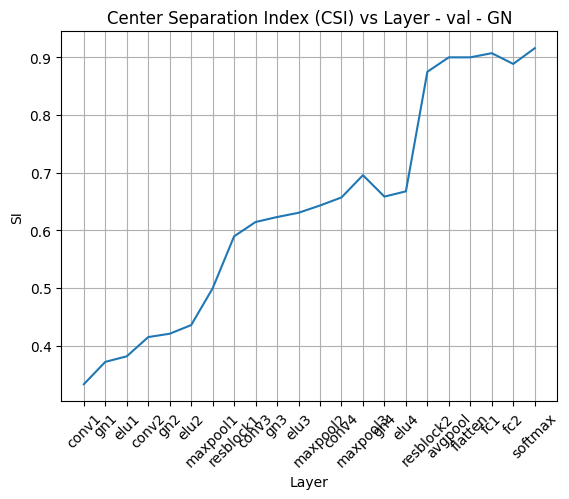

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.21it/s]


### Calc SI

In [10]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 362.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7543.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7206.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7562.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8004.40it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8013.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7140.46it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7500.54it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7676.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8050.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7355.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7796.10it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7541.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7130.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8059.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7614.93it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8179.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7276.72it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8112.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8587.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 9098.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8075.29it/s]


In [11]:
si_layer_test

[('conv1', 0.24329999089241028),
 ('gn1', 0.36629998683929443),
 ('elu1', 0.3723999857902527),
 ('conv2', 0.34109997749328613),
 ('gn2', 0.40849998593330383),
 ('elu2', 0.4075999855995178),
 ('maxpool1', 0.49939998984336853),
 ('resblock1', 0.5845999717712402),
 ('conv3', 0.6193000078201294),
 ('gn3', 0.6291999816894531),
 ('elu3', 0.6287999749183655),
 ('maxpool2', 0.6484999656677246),
 ('conv4', 0.6733999848365784),
 ('maxpool3', 0.6931999921798706),
 ('gn4', 0.6759999990463257),
 ('elu4', 0.6782000064849854),
 ('resblock2', 0.7906999588012695),
 ('avgpool', 0.7879999876022339),
 ('flatten', 0.7879999876022339),
 ('fc1', 0.7797999978065491),
 ('fc2', 0.7760999798774719),
 ('softmax', 0.7576000094413757)]

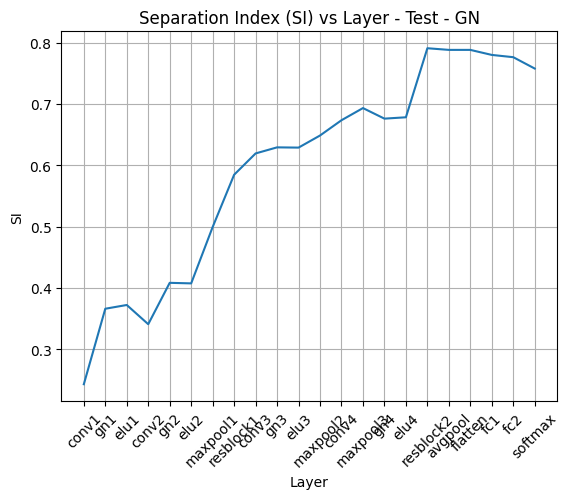

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [13]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 720.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4412.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4604.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4103.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4314.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4890.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3221.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3351.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4332.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4413.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4275.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4325.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3341.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4271.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3109.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3244.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4100.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4312.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4466.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4391.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4229.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4322.24it/s]


[('conv1', 0.34279999136924744), ('gn1', 0.3698999881744385), ('elu1', 0.3790999948978424), ('conv2', 0.4074999988079071), ('gn2', 0.41269999742507935), ('elu2', 0.4274999797344208), ('maxpool1', 0.4908999800682068), ('resblock1', 0.5773000121116638), ('conv3', 0.6024999618530273), ('gn3', 0.6060000061988831), ('elu3', 0.6133999824523926), ('maxpool2', 0.6263999938964844), ('conv4', 0.6448000073432922), ('maxpool3', 0.6796000003814697), ('gn4', 0.6468999981880188), ('elu4', 0.6556999683380127), ('resblock2', 0.814799964427948), ('avgpool', 0.8394999504089355), ('flatten', 0.8394999504089355), ('fc1', 0.8425999879837036), ('fc2', 0.8246999979019165), ('softmax', 0.848800003528595)]


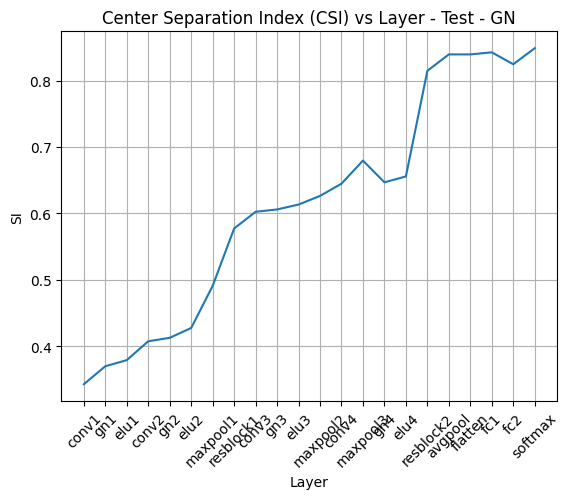

In [14]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - GN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()